# Reflection

https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/reflection/reflection.ipynb

In the context of LLM agent building, reflection refers to **the process of prompting an LLM to observe its past steps (along with potential observations from tools/the environment) to assess the quality of the chosen actions**.
This is then used downstream for things like re-planning, search, or evaluation.

![reflection](reflection.png)

## Setup

First, let's install our required packages and set our API keys

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## Generate

For our example, we will create a "5 paragraph essay" generator. First, create the generator:


In [7]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an essay assistant tasked with writing excellent 5-paragraph essays."
            " Generate the best essay possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
llm = ChatOpenAI(
    model="llama3.2",
    base_url="http://localhost:11434/v1",
)
generate = prompt | llm
generate

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [ ]:
essay = ""
request = HumanMessage(
    content="Write an essay on why the little prince is relevant in modern childhood"
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    essay += chunk.content

### Reflect

In [3]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | llm

In [ ]:
reflection = ""
for chunk in reflect.stream({"messages": [request, HumanMessage(content=essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content

### Repeat

And... that's all there is too it! You can repeat in a loop for a fixed number of steps, or use an LLM (or other check) to decide when the finished product is good enough.

In [ ]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

## Define graph

Now that we've shown each step in isolation, we can wire it up in a graph.

In [4]:
from typing import Annotated, List, Sequence
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


async def generation_node(state: State) -> State:
    return {"messages": [await generate.ainvoke(state["messages"])]}


async def reflection_node(state: State) -> State:
    messages = state["messages"]
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = messages[0]] + [
        cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = await reflect.ainvoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}


builder = StateGraph(State)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


def should_continue(state: State):
    if len(state["messages"]) > 6:
        # End after 3 iterations
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

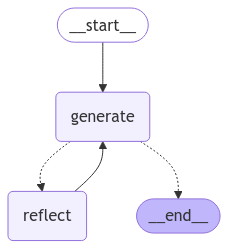

In [5]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
async for event in graph.astream(
    {
        "messages": [
            HumanMessage(
                content="Generate an essay on the topicality of The Little Prince and its message in modern life"
            )
        ],
    },
    config,
):
    print(event)
    print("---")

In [ ]:
state = graph.get_state(config)

In [ ]:
ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()

## Conclusion

Now that you've applied reflection to an LLM agent, I'll note one thing: self-reflection is inherently cyclic: it is much more effective if the reflection step has additional context or feedback (from tool observations, checks, etc.). If, like in the scenario above, the reflection step simply prompts the LLM to reflect on its output, it can still benefit the output quality (since the LLM then has multiple "shots" at getting a good output), but it's less guaranteed.
